In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy

In [2]:
!git clone https://github.com/prajnasb/observations

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 75.94 MiB | 14.00 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [3]:
!ls observations/experiements/dest_folder/

test  test.csv	train  train.csv  val


## Creating image datasets an data loaders for train and test using the experiments folder split

In [4]:
experiments_path = 'observations/experiements/dest_folder/'
data_path = 'observations/experiements/data/'

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [6]:
def get_train_files_path(experiments_path, data_path, phase):
    if phase == 'train':
        file_name = 'train.csv'
    elif phase == 'test':
        file_name = 'test.csv'
    else:
        print("phase can only have train and test as parameter values")
        exit()
    file_path = os.path.join(experiments_path, file_name)
    train_df = pd.read_csv(file_path, delimiter=',')
    files_path = []
    fonts_class = []
    for row in train_df.iterrows():
        files_path.append(os.path.join(data_path, row[1]['class'], row[1]['filename']))
        fonts_class.append(row[1]['class'])
    
    return files_path, fonts_class

In [7]:
def copy_images_to_path(file_path, file_class, destination_dir):
    font_folder = os.path.join(destination_dir, file_class)
    if os.path.exists(font_folder) == False:
        os.makedirs(font_folder)
    
    print("File being copied from {}:{}".format(file_path, font_folder))
    shutil.copy(file_path, font_folder)
    #shutil.copyfile(file_path, font_folder)

In [8]:
X_train, y_train = get_train_files_path(experiments_path, data_path, phase='train')
X_test, y_test = get_train_files_path(experiments_path, data_path, phase='test')

In [9]:
train_dir = os.path.join(experiments_path, 'train')
test_dir = os.path.join(experiments_path, 'test')

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

In [10]:
for file_path, font_class in zip(X_train, y_train):
    copy_images_to_path(file_path, font_class, train_dir)

File being copied from observations/experiements/data/with_mask/0-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/10-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/100-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/101-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/103-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/104-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/105-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/da

In [11]:
for file_path, font_class in zip(X_test, y_test):
    copy_images_to_path(file_path, font_class, test_dir)

File being copied from observations/experiements/data/with_mask/1-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/106-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/11-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/110-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/111-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/114-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/121-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with

In [12]:
image_datasets = {x: datasets.ImageFolder(os.path.join(experiments_path, x), data_transforms[x]) for x in ['train', 'test']}

# list_ = ['train', 'test']
# iamge_datasets = {}

# for x in list_:
#     path = os.path.join(experiments_path, x)
#     image_datasets[x] = datasets.ImageFolder(path, data_transforms[x])

In [13]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 1315
    Root location: observations/experiements/dest_folder/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [14]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 194
    Root location: observations/experiements/dest_folder/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [15]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=16, 
                                             shuffle=True, 
                                             num_workers=4) 
               for x in ['train', 'test']}

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f1b5f6e2c40>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f1b5f6e22e0>}

In [17]:
class_names = image_datasets['train'].classes

In [18]:
class_names

['with_mask', 'without_mask']

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
device

device(type='cuda', index=0)

In [21]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

## Visualising Image

In [22]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [23]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

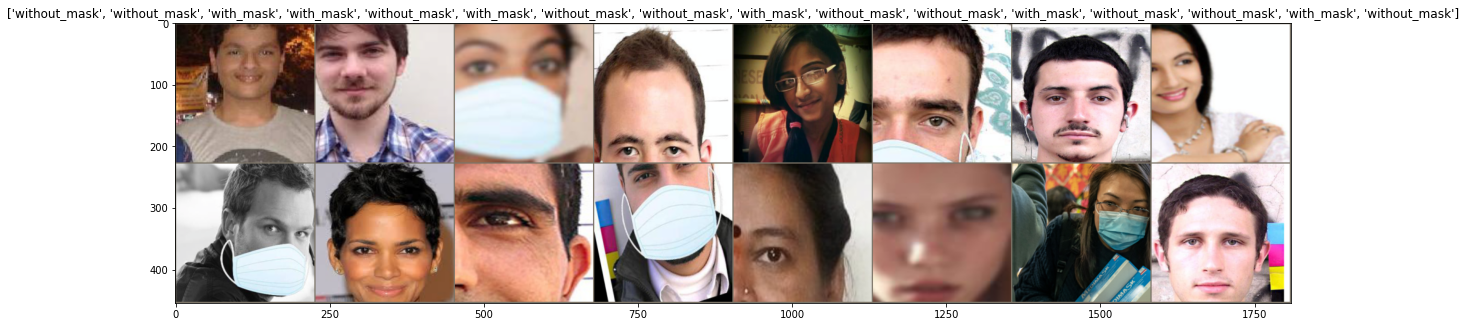

In [24]:
imshow(out, title=[class_names[x] for x in classes])

## Model Training

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    
    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model

In [26]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [27]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [29]:
import torchsummary
torchsummary.summary(model_ft, (3, 224, 224), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 112, 112]           9,408
       BatchNorm2d-2         [16, 64, 112, 112]             128
              ReLU-3         [16, 64, 112, 112]               0
         MaxPool2d-4           [16, 64, 56, 56]               0
            Conv2d-5           [16, 64, 56, 56]           4,096
       BatchNorm2d-6           [16, 64, 56, 56]             128
              ReLU-7           [16, 64, 56, 56]               0
            Conv2d-8           [16, 64, 56, 56]          36,864
       BatchNorm2d-9           [16, 64, 56, 56]             128
             ReLU-10           [16, 64, 56, 56]               0
           Conv2d-11          [16, 256, 56, 56]          16,384
      BatchNorm2d-12          [16, 256, 56, 56]             512
           Conv2d-13          [16, 256, 56, 56]          16,384
      BatchNorm2d-14          [16, 256,

In [30]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.2171 Acc:0.8989

test Loss: 0.0063 Acc:1.0000

Epoch 1/19
----------
train Loss: 0.1127 Acc:0.9521

test Loss: 0.0164 Acc:0.9897

Epoch 2/19
----------
train Loss: 0.0761 Acc:0.9627

test Loss: 0.0001 Acc:1.0000

Epoch 3/19
----------
train Loss: 0.0864 Acc:0.9567

test Loss: 0.0281 Acc:0.9948

Epoch 4/19
----------
train Loss: 0.0950 Acc:0.9544

test Loss: 0.0008 Acc:1.0000

Epoch 5/19
----------
train Loss: 0.0705 Acc:0.9605

test Loss: 0.0015 Acc:1.0000

Epoch 6/19
----------
train Loss: 0.0738 Acc:0.9643

test Loss: 0.0003 Acc:1.0000

Epoch 7/19
----------
train Loss: 0.0546 Acc:0.9711

test Loss: 0.0004 Acc:1.0000

Epoch 8/19
----------
train Loss: 0.0712 Acc:0.9688

test Loss: 0.0010 Acc:1.0000

Epoch 9/19
----------
train Loss: 0.0599 Acc:0.9696

test Loss: 0.0004 Acc:1.0000

Epoch 10/19
----------
train Loss: 0.0764 Acc:0.9627

test Loss: 0.0006 Acc:1.0000

Epoch 11/19
----------
train Loss: 0.0550 Acc:0.9719

test Loss: 0.0005 Acc:1.0000

Epoch 12/19
----------
t

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    #fig = plt.figure(figsize=(10,10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds,"predicitons")
            
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                #ax = plt.subplot(num_images//len(labels)-1, len(labels), images_so_far)
                #ax.axis('off')
                #ax.set_title('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                print('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                #imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [32]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [37]:
torch.save(model_ft.to('cpu'), '/content/gdrive/MyDrive/Project/Mask_Detection_Model/mask_model_resnet101.pth')

In [38]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    #fig = plt.figure(figsize=(10,10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds,"predicitons")
            
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                #ax = plt.subplot(num_images//len(labels)-1, len(labels), images_so_far)
                #ax.axis('off')
                #ax.set_title('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                print('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                #imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [39]:
visualize_model(model_ft.to(device))

tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0') predicitons
true: without_mask predicted: without_mask
true: with_mask predicted: with_mask
true: without_mask predicted: without_mask
true: without_mask predicted: without_mask
true: with_mask predicted: with_mask
true: with_mask predicted: with_mask
